# Diffusion Model Output Analysis

Small notebook to try and play with the outputs from a diffusion model, and see if we can find any patterns!

## Load Data

In [1]:
import json
import pandas as pd
import os

In [20]:
# current options are either 10 or 40 samples
n = 40
tensors_file = f'out_gen/diff_e2e-tgt_block_{n}_samples_tensors.json'
outputs_file = f'out_gen/diff_e2e-tgt_block_{n}_samples.json'

with open(tensors_file) as fin:
    tensor_data = json.load(fin)

with open(outputs_file) as fin:
    output_data = json.load(fin)

In [21]:
key = list(output_data.keys())[0]
key

"('(TOP (S (ADVP (RB Next) (PP (IN to) (NP (DT the) (NNP Yippee) (NNP Noodle) (NNP Bar)))) (NP (EX there)) (VP (VBZ is) (NP (NP (DT a) (ADJP (RB moderately) (JJ good)) (NN restaurant)) (VP (VBN called) (S (NP (NNP Alimentum)))))) (. .) (. \\n)))',)"

In [22]:
tensor_values = tensor_data[key]
len(tensor_values)

2560

In [23]:
output_values = output_data[key]
len(output_values)

2560

In [27]:
def load_index(i, output_values=output_values, tensor_values=tensor_values):
    outputs = [v for j, v in enumerate(output_values) if j % 64 == i]
    tensors = [v for j, v in enumerate(tensor_values) if j % 64 == i]
    return outputs, tensors

## Output Visualization

In [28]:
sequence, tensors = load_index(2)
for s in sequence:
    print('----------------------------------------------')
    print(s)

----------------------------------------------
pounds a the , Bar coffee is friendly a food food and food friendly . can the of Indian restrooms have are The UNK customer 5 average the Golden a are the a . the Waterman food in are friendly near high END fare customers of are . £ UNK are price the price in , Come rate Strada are great 5 , Strada
----------------------------------------------
UNK friendly the . Bar venue is price low 5 food City food friendly . a UNK END Indian a food are The has not has Ranch a Golden a are Fitzbillies the UNK customer Waterman food in are UNK are average is Strada the of are . English UNK are than cheap price food , its . UNK . START , and is
----------------------------------------------
UNK customer the START centre food is START low 5 food UNK . friendly . a average END Indian a food are 5 a customer has Boat a , out are a the UNK UNK Waterman food UNK are UNK near high food Strada the of is the English UNK are coffee a kid food , are . UNK . START 

In [38]:
import re

def get_output_progression(i, gen_index=1):
    sequence, _ = load_index(i)
    gen_outputs = []
    for line in sequence:
        output = re.split('START|END', line)
        cleaned_output = [o for o in output if len(o.strip().split()) > 0]
        gen_outputs.append(cleaned_output[gen_index])
    return gen_outputs

gen_outputs = get_output_progression(2, gen_index=0)
for output in gen_outputs:
    print()
    print(output)


pounds a the , Bar coffee is friendly a food food and food friendly . can the of Indian restrooms have are The UNK customer 5 average the Golden a are the a . the Waterman food in are friendly near high 

UNK friendly the . Bar venue is price low 5 food City food friendly . a UNK 

UNK customer the 

UNK friendly the 

UNK £ the 

UNK £ riverside 

UNK £ the 

are £ riverside range Bar Adriatic is 

are £ riverside range a Adriatic is 

UNK £ the range centre Adriatic is 

UNK £ the 5 a Adriatic is 

Golden a Spice 5 a Adriatic is 

Golden £ the 5 a Wrestlers is a low 5 food less , There UNK UNK average 

Golden £ the 5 a Wrestlers is average low 5 food less , There UNK UNK 

food £ the 5 a Wrestlers is average low 5 food less , There UNK UNK 

food £ the 5 UNK Adriatic is average low 5 food less , of UNK UNK average 

food pub the 5 Café Adriatic is a low 5 food less , of UNK UNK average 

food pub the 5 Café Adriatic is a low 5 food less , of UNK UNK average 

food pub near 5 Café A

## Distance to Output

In [46]:
outputs, tensors = load_index(2)

final_output, final_tensor = outputs[-1], tensors[-1]

print(final_output)

priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults 
 END START Rated 5 out of 5 , The Golden Palace coffee shop offers Italian food and is located in the city centre . 
 END START North of the City centre is a three star restaurant called The Phoenix . 
 END START The Punter Curry


In [47]:
import torch

tensors = torch.tensor(tensors)
print(tensors.shape)

torch.Size([40, 64, 16])


In [48]:
length = 16
sentence_tensors = tensors[:, :length, :]

In [49]:
final_tensor = torch.tensor(final_tensor)
final_tensor = final_tensor[:length, :]
final_tensor.shape

torch.Size([16, 16])

In [53]:
distances = (sentence_tensors - final_tensor).norm(dim=-1)

In [59]:
import pandas as pd

final_sentence = 'priced pub near the Café Adriatic with a cheap 5 star rating , try The Vaults '

data = pd.DataFrame(data=distances.numpy(), columns=final_sentence.split())
data.head()

,priced,pub,near,the,Café,Adriatic,with,a,cheap,5,star,rating,",",try,The,Vaults
0,4.925323,3.820755,4.329145,3.656914,4.697825,5.455966,3.887497,3.807035,3.749250,3.948478,5.223893,4.613241,3.817636,5.287463,3.887732,5.664492
1,4.653749,3.803843,4.080059,3.796135,4.046694,4.136030,3.929493,3.541541,3.575887,2.508029,4.234060,3.855903,3.438363,4.390430,3.804669,5.707790
2,4.225652,4.070982,3.704841,3.785689,4.067625,3.370068,3.493399,4.034652,3.566811,1.996850,3.749669,3.251168,3.132669,4.057143,3.740023,5.565402
3,4.322770,4.335728,3.418202,4.364480,3.804540,2.809829,3.607469,3.953721,3.394342,1.876404,3.358520,3.448673,3.066676,4.135816,3.626653,5.349590
4,4.438329,4.126977,3.055065,4.417415,3.702221,2.266353,3.801577,4.180188,3.408083,1.906184,3.260939,3.298895,3.103324,4.018185,3.448601,5.241084


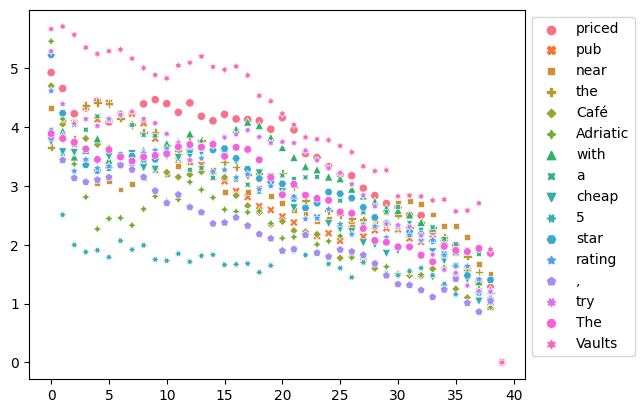

In [64]:
import seaborn as sns

ax = sns.scatterplot(data=data)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))